# Performance Plots for Predictions including 9 encodings

In [12]:
import itertools as it
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

DIR="../data/xtra-berlin"
_nomenclature = {'sumpb' : 'lipb', 'vbc' : 'VB', 'sbc' : 'SB', 'def' : 'Def'}

ptimes = pd.read_csv(f"{DIR}/eval-alltimes.csv.gz")
ptimes

,ID,split,cycle,time_combi,time_combi_fe,time_f2f,time_f2f_fe,time_f2fsr,time_f2fsr_fe,time_sumpb,time_sumpb_fe,time_vbc,time_vwc,time_sbc,time_def
0,bacp/bacp-m1-05-c18-xcsp2018.param,class,10,0.961,1.063,0.961,2.521,0.878,0.980,0.961,1.063,0.863,1.547,0.993,0.997
1,bacp/bacp-m1-06-c18-xcsp2018.param,class,10,1.452,1.572,1.452,2.842,1.452,1.572,1.452,1.572,1.256,2.214,1.460,1.379
2,bacp/bacp-m1-07a-c18-xcsp2018.param,class,10,243.671,243.819,243.671,245.151,243.671,243.819,597.386,597.534,176.584,1106.291,235.787,615.141
3,bacp/bacp-m1-07a-c18-xcsp2018.param,instance,10,282.072,282.220,282.072,283.552,282.072,282.220,282.072,282.220,176.584,1106.291,235.787,615.141
4,bacp/bacp-m1-07b-c18-xcsp2018.param,class,10,3277.261,3277.412,3277.261,3278.751,3277.261,3277.412,36000.000,36000.151,1744.499,36000.000,3326.558,36000.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13198,langford/langford_4_16.param,class,9,9.448,9.671,9.448,10.858,9.448,9.671,9.448,9.671,8.589,50.331,14.681,8.589
13199,langford/langford_6_12.param,class,9,0.928,1.157,0.928,2.468,0.928,1.157,0.928,1.157,0.894,9.426,1.388,0.944
13200,langford/langford_6_16.param,class,9,1.687,2.059,1.687,3.727,1.687,2.059,1.687,2.059,1.500,36000.000,2.825,1.694
13201,langford/langford_6_16.param,instance,9,1.687,2.059,1.687,3.727,1.687,2.059,1.687,2.059,1.500,36000.000,2.825,1.694


In [13]:
#times_ = ptimes.groupby(['split','cycle']).sum().reset_index()
times_ = ptimes.loc[ptimes.cycle<=50].copy()

# we don't need the separate _fe labels, let's just use the time with the fe added in
for c in filter(lambda x:x.endswith('_fe'),times_.columns):
    bare = c[:-3]
    times_ = times_.drop(columns=[bare]).rename(columns={c:bare})

frames = []
for c in [x for x in times_.columns if x.startswith('time_')]:
    if c.endswith('_vwc'): # leave out very worst
        continue
    for split in times_.split.unique():
        selector = c[len('time_'):]
        t = times_.loc[times_.split==split,[c]].copy().reset_index(drop=True)
        t['split'] = split
        t['selector'] = selector
        t['time'] = sorted(t[c])
        t['n_solved'] = list(range(1,len(t)+1))
        frames.append(t.drop(columns=[c]))

cactimes = pd.concat(frames, ignore_index=True)
print("All entries:",len(cactimes))
cactimes = cactimes.groupby(['split','selector','time'])['n_solved'].max().reset_index()
print("Without repeated times:",len(cactimes))

All entries: 92421
Without repeated times: 22780


['combi' 'Def' 'f2f' 'f2fsr' 'SB' 'lipb' 'VB']
instance 6300 out
instance 6300 in
class 7000 out
class 7000 in


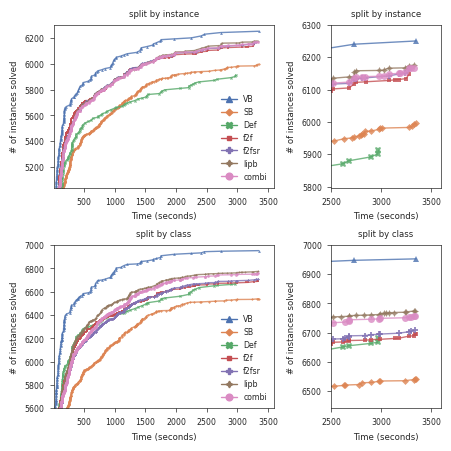

In [17]:
sns.set(
        context="paper", style="ticks", font_scale=0.64,
        rc={
            "font.family": "sans-serif",
            "lines.linewidth"  : 1,
            "axes.linewidth" : 0.5,
            "xtick.major.width" : 0.5,
            "ytick.major.width" : 0.5,
            "xtick.major.size" : 3,
            "ytick.major.size" : 3,
        }
)
for _f, _t in _nomenclature.items():
    cactimes['selector'] = cactimes.selector.str.replace(_f,_t)
print(cactimes.selector.unique())
_ho = ['VB','SB','Def','f2f','f2fsr','lipb','combi']

fig,axs = plt.subplots(2,2,figsize=(4.5,4.5),sharex=False,width_ratios=[2,1])
for i, (split,zoom) in enumerate(it.product(('instance','class'),('out','in'))):
    data = cactimes.loc[cactimes.split==split]
    stop_at = data.loc[data.selector=='VB','time'].max()
    data = data.loc[data.time <= stop_at]
    ax = axs[i//2][i%2]
    sns.lineplot(ax=ax,data=data,x='time',y='n_solved',
                 hue='selector',style='selector',hue_order=_ho,
                 dashes=False,alpha=0.8,markers=True,
                 markersize = 5 if (zoom=='in') else 2,markeredgewidth=0)
    ax.set(title=f'split by {split}',xlabel="Time (seconds)",ylabel="# of instances solved")
    maxdone = (1+(data.n_solved.max() // 100))*100
    print(split,maxdone,zoom)
    if zoom=='in':
        ax.set(xlim=(2500,3600),ylim=(0.92*maxdone,maxdone))
        ax.get_legend().remove()
    else:
        ax.set(xlim=(0.1,3600),ylim=(0.8*maxdone,maxdone))
        ax.legend(loc='lower right', frameon=False)
fig.tight_layout()
fig.savefig('/tmp/survival.pdf',dpi=600)

